# Fine-Tune HyenaDNA On A Downstream Classification Task

In this notebook, we will fine-tune the HynaDNA model on a downstream binary classification task involving cis-regulatory elements.

### Install the package

In [ ]:
# !pip install helical

### Imports

In [ ]:
from helical import HyenaDNA, HyenaDNAConfig, HyenaDNAFineTuningModel
from datasets import load_dataset
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import torch
import logging, warnings
import numpy as np

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

Make use of GPU if there is a GPU present, otherwise default to the CPU

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Dataset Download

- We now use the Hugging Face API to download the [dataset](https://huggingface.co/datasets/InstaDeepAI/genomics-long-range-benchmark)
- We select the task from the list of tasks available for this dataset

In [3]:
label = "regulatory_element_promoter"
dataset_train = load_dataset("InstaDeepAI/genomics-long-range-benchmark", split="train", subset=True, task_name=label, sequence_length=1024, trust_remote_code=True)
dataset_test = load_dataset("InstaDeepAI/genomics-long-range-benchmark", split="test", subset=True, task_name=label, sequence_length=1024, trust_remote_code=True)

Since this is a binary classification task, only 2 labels are present below

In [7]:
for type in np.unique(dataset_train["labels"]):
    print(type)

0
1


### Define our HyenaDNA model and configs

In [8]:
hyena_config = HyenaDNAConfig(model_name="hyenadna-tiny-1k-seqlen-d256", batch_size=5, device=device)
hyena = HyenaDNA(configurer=hyena_config)

### Process the dataset for both training and testing

In [6]:
train_dataset = hyena.process_data(dataset_train["sequence"])
test_dataset = hyena.process_data(dataset_test["sequence"])

Processing sequences: 100%|██████████| 96239/96239 [00:25<00:00, 3842.84it/s]


### Define our fine-tuning model and task type

In [9]:
hyena_fine_tune = HyenaDNAFineTuningModel(hyena, fine_tuning_head="classification", output_size=len(np.unique(dataset_train["labels"])))

### Fine-tune the model

For this we set our training and validation datasets along with their labels

In [10]:
hyena_fine_tune.train(train_input_data=train_dataset, train_labels=dataset_train["labels"], validation_input_data=test_dataset, validation_labels=dataset_test["labels"], optimizer_params={"lr": 0.000001})

  0%|          | 0/20000 [00:00<?, ?it/s]

Fine-Tuning Validation: 100%|██████████| 19248/19248 [00:37<00:00, 518.78it/s, accuracy=0.978]


### Evaluate the fine-tuned model

We now get the outputs of the model on our test dataset and display some results

In [11]:
outputs = hyena_fine_tune.get_outputs(test_dataset)

100%|██████████| 19248/19248 [00:31<00:00, 613.70it/s]


In [12]:
print(classification_report(dataset_test["labels"], outputs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     92410
           1       0.04      0.03      0.03      3829

    accuracy                           0.93     96239
   macro avg       0.50      0.50      0.50     96239
weighted avg       0.92      0.93      0.93     96239



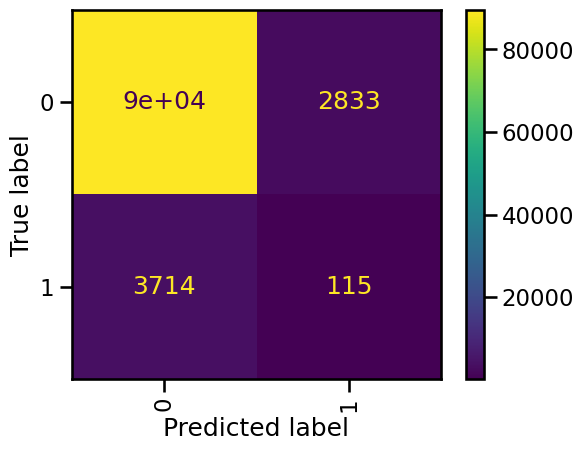

In [13]:
cm_geneformer = confusion_matrix(dataset_test["labels"], outputs.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_geneformer, display_labels=np.unique(np.concatenate((dataset_test["labels"], outputs.argmax(axis=1)))))
disp.plot(xticks_rotation="vertical")